# Introduction
The examples in this chapter from 1-9 aren't really examples at all; we begin with example 2.9.  If you went through Chapter 1, you can continue here.  If not, then you'll need to perform the setup steps below.

# Setup
First load the IPS (short for Introduction to the Practice of Statistics) package and dependencies. If you're doing this for the first time, there may be a great deal more output as the dependent packages are download and compiled. This typically only happens once.

In [1]:
(ql:quickload :ips)

To load "ips":
  Load 1 ASDF system:
    ips
; Loading "ips"
[package yason.system].

(:IPS)

In [2]:
(in-package :ips)

#<PACKAGE "IPS">

# 2.2 Scatterplots
### Example 2.9 Laundry detergents
With the setup complete, we can now load the data:

In [3]:
(defdf detergents-1 (read-csv ips:eg02-08))

#<DATA-FRAME (53 observations of 3 variables)>

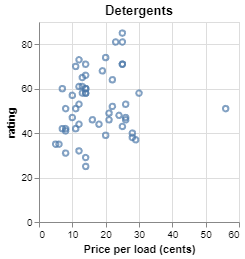

In [5]:
(ips:plot
 (vega:defplot detergents-plot-1
   `(:title "Detergents"
     :data (:values ,detergents-1)
     :mark :point
     :encoding (:x (:field :price  :type "quantitative" :title "Price per load (cents)")
                :y (:field :rating :type "quantitative" )))))

The second figure in this example is the plot with the outlier removed:

In [6]:
(defdf detergents-2 (filter-rows detergents-1 '(< price 40)))

#<DATA-FRAME (52 observations of 3 variables)>

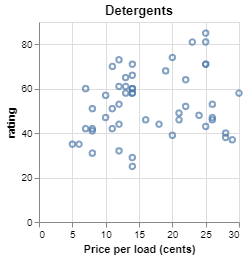

In [8]:
(ips:plot
 (vega:defplot detergents-plot-2
   `(:title "Detergents"
     :data (:values ,detergents-2)
     :mark :point
     :encoding (:x (:field :price  :type "quantitative" :title "Price per load (cents)")
                :y (:field :rating :type "quantitative" )))))

### Example 2.10 Scatterplot with a straight line

Here we obtain the slope and intercept of a line that forms a linear regression for our data points.  To plot that line we'll use the 'fit-line' function in the SCTPLT package.  This package contains functions useful for working with scatterplots in Vega.

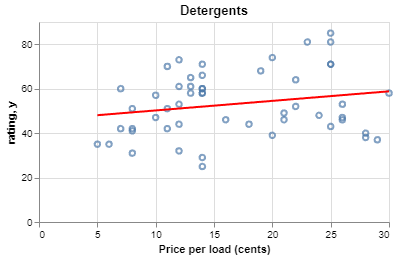

In [9]:
(ips:plot
   (vega:defplot detergents-plot-2
     `(:title "Detergents"
       :width 350
       :data (:values ,detergents-2)
       :layer #((:mark :point
                 :encoding (:x (:field :price  :type "quantitative" :title "Price per load (cents)")
                            :y (:field :rating :type "quantitative")))
       ,(sctplt:fit-line detergents-2:price detergents-2:rating)))))

### Example 2.11: Education spending and population: Benchmarking

The last example had data points spread out widely from the line, indicating only a weak relationship between price and rating.
In this example we see a stronger positive relationship in the spending of states.  We expect that states with higher populations spend more than states with lower populations.  Are some states spending more or less based on their populations?  This type of exercise is known as **benchmarking**, comparing a process or expenditure of an organisation with organisations that share similar characteristics.
The figure below shows a scatter plot of state spending vs. population, with a fitted straight line.

In [10]:
(defdf edu-spending (read-csv eg02-11))

#<DATA-FRAME (50 observations of 3 variables)>

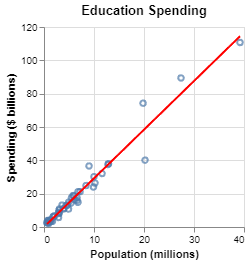

In [12]:
(ips:plot
 (vega:defplot education-spending
   `(:title "Education Spending"
     :data (:values ,edu-spending)
     :layer #((:mark :point
               :encoding (:x (:field :population  :type "quantitative" :title "Population (millions)")
                          :y (:field :spending    :type "quantitative" :title "Spending ($ billions)")))
              ,(sctplt:fit-line edu-spending:population edu-spending:spending)))))

### Example 2.12 Calcium retention
This example trys to answer the question of how much calcium our bodies need.  In the study, the researchers measured the amount of calcium retained by the body as a response variable and the amount consumed as an explanatory variable.  The results are plotted below, with a curve fitted to the data for children aged 11 to 15 years.  You can clearly see there is a relationship, however it is not linear across the range of values.  It starts in a relatively linear manner, then begins to reach a plateau. 

In [13]:
(load #P"IPS:DATA;calcium-retention")

T

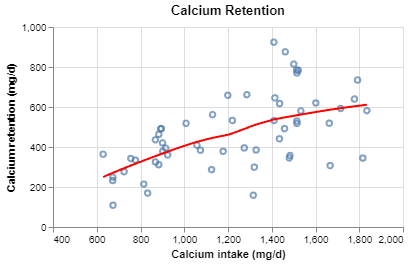

In [15]:
(ips:plot
 (vega:defplot calcium-retention-plot
   `(:title "Calcium Retention"
     :data (:values ,calcium-retention)
     :width 350
     :layer #((:mark :point
               :encoding (:x (:field :caintake  :type "quantitative" :title "Calcium intake (mg/d)" :scale (domain #(500 2000)))
                          :y (:field :caretention :type "quantitative" :title "Calcium retention (mg/d)")))
              ,(sctplt:fit-lowess calcium-retention:caintake calcium-retention:caretention)))))

## The log transformation
One of the most important transformations is the **log transformation**, that is often used to reduce skewness of a variable.  For more information, see [Log-transformation and its implications for data analysis (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/).

### Example 2.13 Calcium retention with logarithms

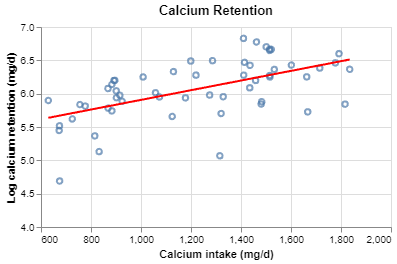

In [17]:
(ips:plot
 (vega:defplot calcium-retention-linear-fit
   `(:title "Calcium Retention"
     :data (:values ,calcium-retention)
     :width 350
     :layer #((:mark :point
               :encoding (:x (:field :caintake  :type "quantitative" :title "Calcium intake (mg/d)" :scale (domain #(600 2000)))
                          :y (:field :logret :type "quantitative" :title "Log calcium retention (mg/d)" :scale (domain #(4 7)))))
              ,(sctplt:fit-line calcium-retention:caintake calcium-retention:logret)))))

### Example 2.14 Education spending and population with logarithms
In this example we will take the log of both variables and fit a line.  Note how we're creating a temporary data frame here rather than modifying the one in the workspace.  This is a common practice when we're experimenting.

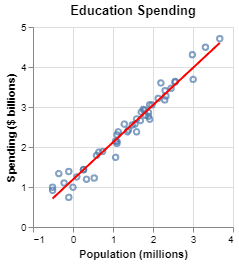

In [19]:
(let ((edu-spending (map-columns (select edu-spending t '(spending population))
				  #'(lambda (x)
				      (elog x))))
      (l-population (elog edu-spending:population))
      (l-spending   (elog edu-spending:spending)))
  (ips:plot
   (vega:defplot log-education-spending
     `(:title "Education Spending"
       :data (:values ,edu-spending)
       :layer #((:mark :point
	   :encoding (:x (:field :population  :type "quantitative" :title "Population (millions)")
                  :y (:field :spending    :type "quantitative" :title "Spending ($ billions)")))
		,(sctplt:fit-line l-population l-spending))))))

## Adding categorical variables to scatterplots
In example 2.10 we investigated the relationship between the rating and price per load for 52 laundry detergents. Looking more closely, we can see that there are two different types of laundry detergent, liquid and powder.  We can add these categorical variables to the scatter plot by using a different colour for each one.
Note how we slice up the data in the `let*` statement, allowing us to plot the elements individually.

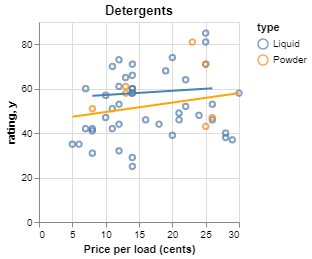

In [20]:
(let* ((liquids (filter-rows detergents-2 '(string= "Liquid" type)))
       (powders (filter-rows detergents-2 '(string= "Powder" type)))
       (l-price  (select liquids t 'price))
       (l-rating (select liquids t 'rating))
       (p-price  (select powders t 'price))
       (p-rating (select powders t 'rating)))
  (ips:plot
   (vega:defplot detergents-plot-2
     `(:title "Detergents"
       :data (:values ,detergents-2)
       :layer #((:mark :point
	             :encoding (:x (:field :price  :type "quantitative" :title "Price per load (cents)")
			                :y (:field :rating :type "quantitative" )
			                :color (:field "type" :type "nominal")))
		        ,(sctplt:fit-line l-price l-rating :color :orange)
		        ,(sctplt:fit-line p-price p-rating :color :steelblue))))))

## Scatterplot smoothers
In this above example, we fit a line to the curve, but some data isn't linear.  To fit a smooth line to these, we can use various smoothers, the most common of which is `lowess`, seen in the calcium retention plots.  There is a variable you should be aware of, call the **smoothing parameter** that determines how closely the curve follows the data.  Let's see this by repeating the calcium plots with two different values for the smoothing parameter.

### Example 2.16 Laundry rating vs. price with a smooth fit
First, the plot with a small value of the smoothing parameter:

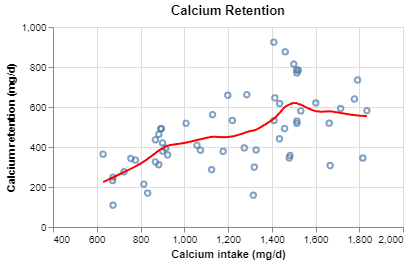

In [22]:
(ips:plot
 (vega:defplot calcium-retention-plot-smooth
   `(:title "Calcium Retention"
     :data (:values ,calcium-retention)
     :width 350
     :layer #((:mark :point
               :encoding (:x (:field :caintake  :type "quantitative" :title "Calcium intake (mg/d)" :scale (domain #(500 2000)))
                          :y (:field :caretention :type "quantitative" :title "Calcium retention (mg/d)")))
              ,(sctplt:fit-lowess calcium-retention:caintake calcium-retention:caretention :span 1/3)))))

And now with the default value (2/3):

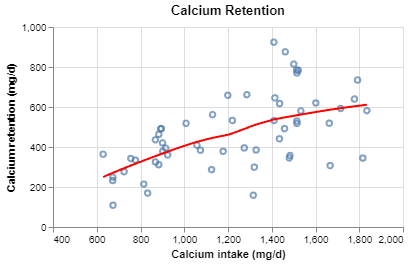

In [23]:
(ips:plot
 (vega:defplot calcium-retention-plot
   `(:title "Calcium Retention"
     :data (:values ,calcium-retention)
     :width 350
     :layer #((:mark :point
               :encoding (:x (:field :caintake  :type "quantitative" :title "Calcium intake (mg/d)" :scale (domain #(500 2000)))
                          :y (:field :caretention :type "quantitative" :title "Calcium retention (mg/d)")))
              ,(sctplt:fit-lowess calcium-retention:caintake calcium-retention:caretention)))))

### Example 2.17 A smooth fit for education spanding and population with logs
This scatterplot of log education spending versus log population with a smooth curve suggests that the relationship is approximately linear except for states with relatively small populations.  For them, spending is relatively flat.  Note that this is the same plot as Example 1.14, except using the lowess smoother instead of a linear fit.

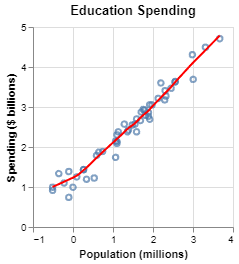

In [32]:
(let ((edu-spending (map-columns (select edu-spending t '(spending population))
				                  #'(lambda (x)
				                      (elog x))))
      (l-population (elog edu-spending:population))
      (l-spending   (elog edu-spending:spending)))
  (ips:plot
   (vega:defplot log-education-spending-smooth
     `(:title "Education Spending"
       :data (:values ,edu-spending)
       :layer #((:mark :point
	             :encoding (:x (:field :population  :type "quantitative" :title "Population (millions)")
                            :y (:field :spending    :type "quantitative" :title "Spending ($ billions)")))
		        ,(sctplt:fit-lowess l-population l-spending :span 1/4))))))